# HetRec 2011
---
The 2nd International Workshop on Information Heterogeneity and Fusion in Recommender Systems (HetRec 2011, http://ir.ii.uam.es/hetrec2011) has released datasets from Delicious, Last.fm Web 2.0, MovieLens, IMDb, and Rotten Tomatoes. These datasets contain social networking, tagging, and resource consuming (Web page bookmarking and music artist listening) information from sets of around 2,000 users.

The datasets were generated by the Information Retrieval Group at Universidad Autónoma de Madrid (http://ir.ii.uam.es). Before using these datasets, please review the README files for the usage license and other details.

---

In [1]:
import numpy as np
import pandas as pd

import csv
import os

from tqdm.notebook import tqdm

from scipy.spatial.distance import squareform
from scipy.spatial.distance import cdist

from sklearn.preprocessing import Normalizer, MinMaxScaler

import torch
import torch.nn.functional as F
from torch.autograd import Variable
from torch import nn

import fasttext
import fasttext.util

from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

# Data loding
---

In [2]:
def dat_to_csv(dat_file, has_header=True, delimiter=',', save=False):
    with open(dat_file, 'r', encoding='cp437') as f:
        lines = f.read().split('\n')[:-1]
    
    if has_header:
        columns = lines[0].split(delimiter)
        lines = lines[1:]
    else:
        columns = [f'Column {i}' for i in range(len(lines[0].split(delimiter)))]
    
    df = pd.DataFrame(np.array([l.split(delimiter) for l in lines]), columns=columns)
    if save:
        df.to_csv(dat_file.replace('.dat', '.csv'))
    
    return df

## Last.FM (artists)

In [3]:
df_lf_artists = dat_to_csv('hetrec2011/hetrec2011-lastfm-2k/artists.dat', delimiter='\t')
df_lf_tags = dat_to_csv('hetrec2011/hetrec2011-lastfm-2k/tags.dat', delimiter='\t')
df_lf_usertagged = dat_to_csv('hetrec2011/hetrec2011-lastfm-2k/user_taggedartists-timestamps.dat', delimiter='\t')

In [4]:
df_lf_artists = df_lf_artists[['id', 'name']]
df_lf_artists.head()

,id,name
0,1,MALICE MIZER
1,2,Diary of Dreams
2,3,Carpathian Forest
3,4,Moi dix Mois
4,5,Bella Morte


In [5]:
df_lf_tags.head()

,tagID,tagValue
0,1,metal
1,2,alternative metal
2,3,goth rock
3,4,black metal
4,5,death metal


In [6]:
df_lf_usertagged = df_lf_usertagged[['userID', 'artistID', 'tagID']]
df_lf_usertagged.head()

,userID,artistID,tagID
0,2,52,13
1,2,52,15
2,2,52,18
3,2,52,21
4,2,52,41


In [7]:
print(f'Artists: {len(df_lf_artists)}')
print(f'Tags: {len(df_lf_tags)}')
print(f'Artist user taggings: {len(df_lf_usertagged)}')

Artists: 17632
Tags: 11946
Artist user taggings: 186479


## MovieLens + IMDb/Rotten Tomatoes (movies)

In [8]:
df_ml_movies = dat_to_csv('hetrec2011/hetrec2011-movielens-2k-v2/movies.dat', delimiter='\t')
df_ml_tags = dat_to_csv('hetrec2011/hetrec2011-movielens-2k-v2/tags.dat', delimiter='\t')
df_ml_moviegenres = dat_to_csv('hetrec2011/hetrec2011-movielens-2k-v2/movie_genres.dat', delimiter='\t')
df_ml_usertagged = dat_to_csv('hetrec2011/hetrec2011-movielens-2k-v2/user_taggedmovies-timestamps.dat', delimiter='\t')
df_ml_userrated = dat_to_csv('hetrec2011/hetrec2011-movielens-2k-v2/user_ratedmovies-timestamps.dat', delimiter='\t')

In [9]:
df_ml_movies = df_ml_movies[['id', 'title']]
df_ml_movies.head()

,id,title
0,1,Toy story
1,2,Jumanji
2,3,Grumpy Old Men
3,4,Waiting to Exhale
4,5,Father of the Bride Part II


In [10]:
df_ml_tags.head()

,id,value
0,1,earth
1,2,police
2,3,boxing
3,4,painter
4,5,whale


In [11]:
df_ml_moviegenres.head()

,movieID,genre
0,1,Adventure
1,1,Animation
2,1,Children
3,1,Comedy
4,1,Fantasy


In [12]:
df_ml_usertagged = df_ml_usertagged[['userID', 'movieID', 'tagID']]
df_ml_usertagged.head()

,userID,movieID,tagID
0,75,353,5290
1,78,4223,5264
2,127,1343,1544
3,127,1343,12330
4,127,2080,1451


In [13]:
df_ml_userrated = df_ml_userrated[['userID', 'movieID', 'rating']]
df_ml_userrated.head()

,userID,movieID,rating
0,75,3,1
1,75,32,4.5
2,75,110,4
3,75,160,2
4,75,163,4


In [14]:
print(f'Movies: {len(df_ml_movies)}')
print(f'Tags: {len(df_ml_tags)}')
print(f'Genres: {len(df_ml_moviegenres)}')
print(f'Artist user taggings: {len(df_ml_usertagged)}')
print(f'Artist user ratings: {len(df_ml_userrated)}')

Movies: 10197
Tags: 13222
Genres: 20809
Artist user taggings: 47957
Artist user ratings: 855598


# Data analysis
---

## Tagclouds

In [15]:
def get_tags(df_usertagged, df_tags, tagcols=('tagID', 'id', 'value'), freq_thr=100, shuffle=True):
    df_common = df_usertagged.merge(df_tags, left_on=tagcols[0], right_on=tagcols[1])
    
    tags_list = np.array([f"#{t.replace(' ', '_')}" for t in df_common[tagcols[2]]])
    
    # reduce to tags above freq_thr value
    tags_list = most_frequent_above(tags_list, freq_thr)
    
    if shuffle:
        np.random.shuffle(tags_list)
    
    return tags_list

def most_frequent_above(tags, freq_thr=100):
    freq_dict = dict()
    for tag in tags:
        if tag not in freq_dict:
            freq_dict[tag] = 0
        freq_dict[tag] += 1
    
    top_tags = list(filter(lambda x: x[1] >= freq_thr, freq_dict.items()))
    return [tt[0] for tt in top_tags]

def generate_wordcloud(text, title, max_words=10000, save_file=None):
    wc = WordCloud(max_words=10000, height=400, width=800, stopwords=set(STOPWORDS), margin=10, random_state=1).generate(text)
    plt.figure(figsize=(14, 20))
    plt.title(title)
    plt.axis("off")
    plt.imshow(wc, interpolation='bilinear')
    if save_file:
        plt.savefig(save_file)
    plt.show()

In [16]:
lf_tags = get_tags(df_lf_usertagged, df_lf_tags, tagcols=('tagID', 'tagID', 'tagValue'))
ml_tags = get_tags(df_ml_usertagged, df_ml_tags)

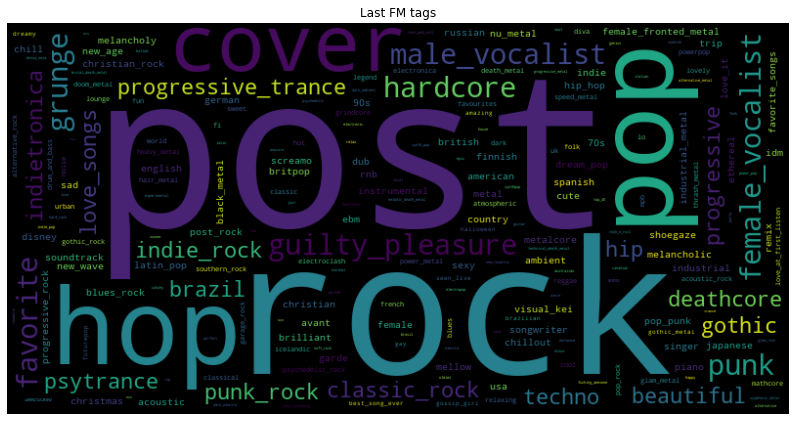

In [17]:
generate_wordcloud(' '.join(lf_tags), title='Last FM tags',
                   max_words=50000, save_file='hetrec2011/lf_tags.png')

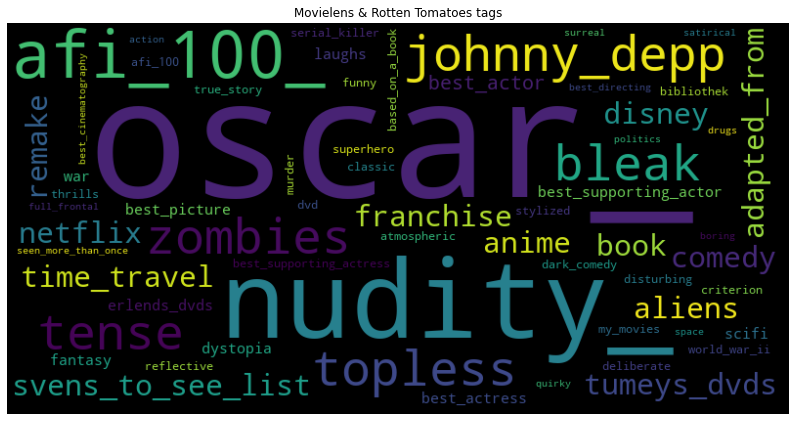

In [18]:
generate_wordcloud(' '.join(ml_tags), title='Movielens & Rotten Tomatoes tags',
                   max_words=25000, save_file='hetrec2011/ml_tags.png')

In [19]:
n_lf_tags = np.size(np.unique(lf_tags))
n_ml_tags = np.size(np.unique(ml_tags))

## Common tags

In [20]:
def common_tags(s1, s2):
    return np.intersect1d(np.unique(s1), np.unique(s2))

In [21]:
ct = common_tags(lf_tags, ml_tags)
print(f'Common tags in music and video:\nFirst 10: {ct[:10]}\nLast 10: {ct[-10:]}')
print(f'Music tags: {n_lf_tags} | Movie tags: {n_ml_tags} | Common count: {np.size(ct)}')

Common tags in music and video:
First 10: ['#atmospheric' '#classic' '#disney']
Last 10: ['#atmospheric' '#classic' '#disney']
Music tags: 227 | Movie tags: 59 | Common count: 3


So, it is useless to compare for example movies and music using jaccard score. Almost always it would be 0. <br />
Better to vectorize all tags, calculate cosine similarity matrix for each two sets of tags and get mean score.

# Movies recommendation
---
**First correct movie and user indices in order to perform martix factorization task.**<br />
Aspects according to given user id:
- predicted movie ratings for user (matrix factorization / deep learning)
- movie genres similarity (content based approach)
- movie titles similarity (content based approach)
- movie user tagging similarity (collaborative filtering approach)

## Movies and users id correction

First change indices data type from 'str' appropriately to 'np.int32' or 'np.float32'.

In [22]:
df_ml_userrated['userID'] = df_ml_userrated['userID'].astype(np.int32)
df_ml_userrated['movieID'] = df_ml_userrated['movieID'].astype(np.int32)
df_ml_userrated['rating'] = df_ml_userrated['rating'].astype(np.float32)

df_ml_usertagged['userID'] = df_ml_usertagged['userID'].astype(np.int32)
df_ml_usertagged['movieID'] = df_ml_usertagged['movieID'].astype(np.int32)
df_ml_usertagged['tagID'] = df_ml_usertagged['tagID'].astype(np.int32)

df_ml_movies['id'] = df_ml_movies['id'].astype(np.int32)

df_ml_tags['id'] = df_ml_tags['id'].astype(np.int32)

df_ml_moviegenres['movieID'] = df_ml_moviegenres['movieID'].astype(np.int32)

In [23]:
users = df_ml_userrated['userID'].values
items = df_ml_userrated['movieID'].values
ui_ratings = df_ml_userrated['rating'].values

n_users = len(np.unique(users))
n_items = len(np.unique(items))

print(f'Users: {n_users}')
print(f'Items: {n_items}')
print(f'Ratings: {len(ui_ratings)}')
print(f'Max user_id: {np.max(users)}')
print(f'Max item_id: {np.max(items)}')

Users: 2113
Items: 10109
Ratings: 855598
Max user_id: 71534
Max item_id: 65133


Maximum user index 71534 and item index 65133 are out of range: 2113 and 10109. Need to reset indices.

In [24]:
user_mapping = dict(zip(np.unique(users), range(n_users)))
item_mapping = dict(zip(np.unique(items), range(n_items)))

In [25]:
df_ml_userrated['userID'] = df_ml_userrated['userID'].replace(user_mapping)
df_ml_userrated['movieID'] = df_ml_userrated['movieID'].replace(item_mapping)

df_ml_usertagged['userID'] = df_ml_usertagged['userID'].replace(user_mapping)
df_ml_usertagged['movieID'] = df_ml_usertagged['movieID'].replace(item_mapping)

df_ml_movies['id'] = df_ml_movies['id'].replace(item_mapping)

In [26]:
users = df_ml_userrated['userID'].values
items = df_ml_userrated['movieID'].values
ui_ratings = df_ml_userrated['rating'].values

n_users = len(np.unique(users))
n_items = len(np.unique(items))

print(f'Users: {n_users}')
print(f'Items: {n_items}')
print(f'Max user_id: {np.max(users)}')
print(f'Max item_id: {np.max(items)}')

Users: 2113
Items: 10109
Max user_id: 2112
Max item_id: 10108


Now it's ok.

## Rating - Dense Feedforward NN

In [27]:
def user_ratings(user_id):
    df_common = df_ml_userrated.merge(df_ml_movies, left_on='movieID', right_on='id')
    return df_common.loc[df_common['userID'] == user_id][['movieID', 'title', 'rating']]\
    .sort_values('rating', ascending=False)

In [28]:
df_user5_ratings = user_ratings(5)
df_user5_ratings

,movieID,title,rating
75117,1078,Star Wars: Episode V - The Empire Strikes Back,5.0
351662,7397,Harry Potter and the Prisoner of Azkaban,5.0
29127,5573,The Lord of the Rings: The Two Towers,5.0
27376,4653,The Lord of the Rings: The Fellowship of the Ring,5.0
25417,3486,X-Men,5.0
...,...,...,...
333202,3827,Hannibal,0.5
324416,2668,Risky Business,0.5
4664,285,Pulp Fiction,0.5
263734,570,The Silence of the Lambs,0.5


In [29]:
df_user17_ratings = user_ratings(17)
df_user17_ratings

,movieID,title,rating
263,31,Twelve Monkeys,5.0
215933,46,Shichinin no samurai,5.0
245470,4623,Ocean's Eleven,5.0
241045,3695,Snatch.,5.0
553506,9514,Rocket Science,5.0
...,...,...,...
241983,3983,Shrek,3.5
617349,647,Operation Dumbo Drop,3.0
617152,527,Super Mario Bros.,3.0
419754,9530,3:10 to Yuma,2.0


### Helpers

In [30]:
def batch(l, size):
    for i in range(0, len(l), size):
        yield l[i:i+size]

def as_numpy(ttensor):
    return ttensor.detach().numpy()

### Model

In [31]:
class DenseNet(torch.nn.Module):

    def __init__(self, n_users, n_items, n_factors, H1, D_out):
        """
        Simple Feedforward with Embeddings
        """
        super().__init__()
        # user and item embedding layers
        self.user_factors = torch.nn.Embedding(n_users, n_factors, sparse=True)
        self.item_factors = torch.nn.Embedding(n_items, n_factors, sparse=True)
        # dropout after embeddings
        self.dropout1 = torch.nn.Dropout(0.1)
        # linear layers
        self.linear1 = torch.nn.Linear(n_factors*2, H1)
        self.linear2 = torch.nn.Linear(H1, H1)
        self.linear3 = torch.nn.Linear(H1, H1)
        self.linear4 = torch.nn.Linear(H1, D_out)
        # dropout after linear layers
        self.dropout2 = torch.nn.Dropout(0.1)

    def forward(self, users, items):
        users_embedding = self.user_factors(users)
        items_embedding = self.item_factors(items)
        # concatenate user and item embeddings to form input
        x = torch.cat([users_embedding, items_embedding], 1)
        x = self.dropout1(x)
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = F.relu(self.linear3(x))
        x = self.dropout2(self.linear4(x))
        output_scores = torch.sigmoid(x)*5
        
        return output_scores

    def predict(self, users, items):
        # return the score
        output_scores = self.forward(users, items)
        return output_scores

Reduce given dataframe (with user ids) to certain group of users (by given user indices).

In [32]:
class RatingPredictor():
    
    def __init__(self, user_ids, item_ids, ui_ratings, n_factors, h1):
        """
        Movie ratings predictor for certain group of users.
        """
        self.user_ids = user_ids
        # map items indices in order to get rid of gaps in current indexing
        rng = np.arange(np.size(np.unique(item_ids)))
        mapping = dict(zip(np.unique(item_ids), rng))
        self.item_ids = np.vectorize(lambda x: mapping[x])(item_ids)
        
        self.ui_ratings = ui_ratings
        self.n_users = np.size(np.unique(user_ids))
        self.n_items = np.size(np.unique(item_ids))
        
        self.n_factors = n_factors
        self.h1 = h1
        
        self.__model = DenseNet(self.n_users, self.n_items, n_factors=self.n_factors, H1=self.h1, D_out=1)
        self.__loss = torch.nn.MarginRankingLoss()
        self.__optim = torch.optim.SGD(self.__model.parameters(), lr=1e-6)
        
    
    def fit(self, epochs, batch_size, save_progress=False):
        if save_progress:
            with open(f'hetrec2011/mr_prog_{self.n_factors}f_{self.h1}h.csv', 'w') as f:
                csv.writer(f).writerow(['epoch loss'])
        
        t = tqdm(range(epochs))
        for epoch in t:
            t.set_postfix_str(f'Epoch {epoch + 1}/{epochs}')
            us_b = batch(self.user_ids, size=batch_size)
            is_b = batch(self.item_ids, size=batch_size)
            uirs_b = batch(self.ui_ratings, size=batch_size)
            epoch_loss = 0
            
            tt = tqdm(zip(us_b, is_b, uirs_b),
                      total=int(np.size(self.ui_ratings)/batch_size + 1), leave=False)
            for u, i, uir in tt:
                # get user, item and rating data batch
                user = Variable(torch.LongTensor(u))
                item = Variable(torch.LongTensor(i))
                rating = Variable(torch.FloatTensor(uir))

                # predict
                prediction = self.__model(user, item)
                target = (prediction.reshape(-1) <= rating).int() - (prediction.reshape(-1) > rating).int()
                loss = self.__loss(prediction.reshape(-1), rating, target)
                epoch_loss += loss.detach().numpy()
                tt.set_postfix_str(f'Current MR loss: {np.round(np.float64(loss.detach().numpy()), 4)} ' +
                                   f'| Total: {np.round(epoch_loss, 4)}')

                # backpropagate
                loss.backward()

                # update weights
                self.__optim.step()
            
            #save current movie-rating progress step
            if save_progress:
                with open(f'hetrec2011/mr_prog_{self.n_factors}f_{self.h1}h.csv', 'a+') as f:
                    csv.writer(f).writerow([epoch_loss])
    
    def predict(self, user_id):
        users_tensor = torch.tensor([user_id]*np.size(self.item_ids))
        items_tensor = torch.tensor(self.item_ids)
        return as_numpy(self.__model(users_tensor, items_tensor).flatten())

### Tests

In [33]:
BATCH_SIZE = 64
EPOCHS = 5

In [34]:
RP_MODEL_PATH = 'hetrec2011/rp_model'

In [35]:
df_userrated_titles = df_ml_userrated.merge(df_ml_movies, left_on='movieID', right_on='id')
df_userrated_titles

,userID,movieID,rating,id,title
0,0,2,1.0,2,Grumpy Old Men
1,22,2,2.0,2,Grumpy Old Men
2,23,2,3.5,2,Grumpy Old Men
3,33,2,4.0,2,Grumpy Old Men
4,35,2,2.5,2,Grumpy Old Men
...,...,...,...,...,...
858586,2103,9998,3.0,9998,Fifty Pills
858587,2104,3285,4.0,3285,The Great Locomotive Chase
858588,2104,9763,1.5,9763,Chapter 27
858589,2106,4094,2.5,4094,Blackout


In [36]:
INPUT_FACTORS = 20
HIDDEN_FACTORS = 10

In [37]:
if not os.path.exists(RP_MODEL_PATH):
    rp = RatingPredictor(
        df_userrated_titles['userID'].values,
        df_userrated_titles['movieID'].values,
        df_userrated_titles['rating'].values,
        n_factors=INPUT_FACTORS, h1=HIDDEN_FACTORS)
    rp.fit(epochs=EPOCHS, batch_size=BATCH_SIZE, save_progress=True)
    torch.save(rp, RP_MODEL_PATH)
else:
    rp = torch.load(RP_MODEL_PATH)

In [38]:
def prediction_quality_plot(input_file, title, save_file=None):
    df = pd.read_csv(input_file)
    
    plt.plot(df.index + 1, df['epoch loss'], label='epoch margin ranking loss')
    plt.xticks(df.index + 1)
    
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    
    plt.legend(loc='best')
    
    if save_file:
        plt.savefig(save_file)
    plt.show()

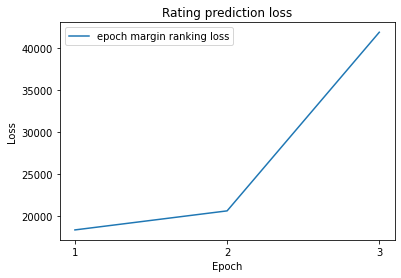

In [39]:
prediction_quality_plot(input_file=f'hetrec2011/mr_prog_{INPUT_FACTORS}f_{HIDDEN_FACTORS}h.csv',
                        title='Rating prediction loss',
                        save_file=f'hetrec2011/rating_prediction_loss_{INPUT_FACTORS}f_{HIDDEN_FACTORS}h.png')

In [40]:
def ratings_recommendations(df, predictions):
    
    df_all = pd.DataFrame({
        'movieID': df['movieID'].values,
        'title': df['title'].values,
        'pred. rating': predictions
    }).drop_duplicates()
    
    df_all = df_all.groupby(['movieID', 'title'])['pred. rating'].apply(np.max).to_frame().reset_index()
    
    return df_all.sort_values('pred. rating', ascending=False)

In [41]:
df_user5_ratings_recommendations = ratings_recommendations(df_userrated_titles, rp.predict(5))
df_user5_ratings_recommendations

,movieID,title,pred. rating
0,0,Toy story,4.999985
6767,6730,Paycheck,4.999985
6760,6723,The Fog of War: Eleven Lessons from the Life o...,4.999985
6761,6724,The Hebrew Hammer,4.999985
6762,6725,House of Sand and Fog,4.999985
...,...,...,...
9893,9839,Canicule,2.500000
7849,7803,The Alligator People,2.500000
8962,8908,First Descent,2.500000
2440,2430,It Conquered the World,2.500000


In [42]:
df_user17_ratings_recommendations = ratings_recommendations(df_userrated_titles, rp.predict(17))
df_user17_ratings_recommendations

,movieID,title,pred. rating
0,0,Toy story,4.999985
6765,6728,Cheaper by the Dozen,4.999985
6758,6721,Mona Lisa Smile,4.999985
6759,6722,Calendar Girls,4.999985
6760,6723,The Fog of War: Eleven Lessons from the Life o...,4.999985
...,...,...,...
800,796,Girls Town,2.500000
4753,4727,American Adobo,2.500000
4534,4508,The Learning Curve,2.500000
1537,1530,Man of Her Dreams,2.500000


## Genres - Content Based Approach

Each movie has a list of assigned genres. Task is to calculate Jaccard similarity for each movie to each i.e. to construct Jaccard similarity matrix.

In [43]:
genres = np.unique(df_ml_moviegenres['genre'])
genres

array(['Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime',
       'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'IMAX',
       'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Short', 'Thriller',
       'War', 'Western'], dtype=object)

In [44]:
# first aggregate (to numpy array) movie genres dataframe by movieID
srs_moviegenres = df_ml_moviegenres.groupby('movieID')['genre'].apply(np.array).values
srs_moviegenres

array([array(['Adventure', 'Animation', 'Children', 'Comedy', 'Fantasy'],
      dtype=object),
       array(['Adventure', 'Children', 'Fantasy'], dtype=object),
       array(['Comedy', 'Romance'], dtype=object), ...,
       array(['Comedy', 'Drama'], dtype=object),
       array(['Drama', 'Romance'], dtype=object),
       array(['Comedy'], dtype=object)], dtype=object)

In [45]:
# build zero-one genres dataframe
df_moviegenres_zeroone = pd.DataFrame([{g: 1 if g in mgs else 0 for g in genres} for mgs in srs_moviegenres])
df_moviegenres_zeroone

,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Short,Thriller,War,Western
0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10192,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10193,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0
10194,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
10195,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0


In [46]:
jaccard_mtx = cdist(df_moviegenres_zeroone, df_moviegenres_zeroone, 'jaccard')
jaccard_mtx = np.subtract(np.ones(jaccard_mtx.shape), jaccard_mtx)

df_jaccard_sim = pd.DataFrame(jaccard_mtx,
                              index=df_moviegenres_zeroone.index,
                              columns=df_moviegenres_zeroone.index)
df_jaccard_sim

,0,1,2,3,4,5,6,7,8,9,...,10187,10188,10189,10190,10191,10192,10193,10194,10195,10196
0,1.000000,0.6,0.166667,0.142857,0.200000,0.0,0.166667,0.400000,0.0,0.142857,...,0.0,0.0,0.0,0.166667,0.000000,0.600000,0.000000,0.166667,0.000000,0.200000
1,0.600000,1.0,0.000000,0.000000,0.000000,0.0,0.000000,0.666667,0.0,0.200000,...,0.0,0.0,0.0,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000
2,0.166667,0.0,1.000000,0.666667,0.500000,0.0,1.000000,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.333333,0.000000,0.250000,0.250000,0.333333,0.333333,0.500000
3,0.142857,0.0,0.666667,1.000000,0.333333,0.0,0.666667,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.666667,0.333333,0.200000,0.500000,0.666667,0.666667,0.333333
4,0.200000,0.0,0.500000,0.333333,1.000000,0.0,0.500000,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.500000,0.000000,0.333333,0.000000,0.500000,0.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10192,0.600000,0.5,0.250000,0.200000,0.333333,0.0,0.250000,0.666667,0.0,0.200000,...,0.0,0.0,0.0,0.250000,0.000000,1.000000,0.000000,0.250000,0.000000,0.333333
10193,0.000000,0.0,0.250000,0.500000,0.000000,0.2,0.250000,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.250000,0.333333,0.000000,1.000000,0.250000,0.666667,0.000000
10194,0.166667,0.0,0.333333,0.666667,0.500000,0.0,0.333333,0.000000,0.0,0.000000,...,0.0,0.0,0.0,1.000000,0.500000,0.250000,0.250000,1.000000,0.333333,0.500000
10195,0.000000,0.0,0.333333,0.666667,0.000000,0.0,0.333333,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.333333,0.500000,0.000000,0.666667,0.333333,1.000000,0.000000


In [47]:
N_HIGHEST = 10

Take **N_HIGHEST** user movie ratings and then for each taken movie, take jaccards similarities. Stack them vertically and calculate root squared mean similarity aggregating by 'movieID'.

In [48]:
def users_genres_most_similar(df, n_highest=N_HIGHEST):
    df_highest = df[:n_highest][['movieID']]
    
    df_all = pd.DataFrame(columns=df_highest.columns)
    
    for i, row in df_highest.iterrows():
        sims = df_jaccard_sim[int(row['movieID'])].values
        df_sims = pd.DataFrame({
            'movieID': df_jaccard_sim.index,
            's': sims
        })
        
        df_all = pd.concat([df_all, df_sims])
    
    df_all = df_all.groupby('movieID')['s'].apply(np.sum)
    
    df_all = pd.DataFrame({
        'movieID': df_all.index,
        'sum sim.': df_all.values
    })
    
    return df_all.merge(df_ml_movies, left_on='movieID', right_on='id')[['movieID', 'title', 'sum sim.']]\
                 .sort_values('sum sim.', ascending=False)

In [49]:
df_user5_genres_similarities = users_genres_most_similar(df_user5_ratings)
df_user5_genres_similarities

,movieID,title,sum sim.
3113,3098,Volunteers,2.927778
3228,3211,Network,2.927778
8937,8883,Zombie ja Kummitusjuna,2.927778
213,213,Don Juan DeMarco,2.927778
4706,4680,Silent Trigger,2.927778
...,...,...,...
2285,2275,200 Cigarettes,0.000000
4048,4025,Catch-22,0.000000
4052,4029,Uncommon Valor,0.000000
8826,8773,Man of the West,0.000000


In [50]:
df_user17_genres_similarities = users_genres_most_similar(df_user17_ratings)
df_user17_genres_similarities

,movieID,title,sum sim.
2896,2885,U2: Rattle and Hum,3.166667
6964,6925,The Ladykillers,3.166667
7603,7558,Roxanne,3.166667
2933,2920,Play It to the Bone,3.166667
1537,1530,Man of Her Dreams,3.166667
...,...,...,...
3613,3592,Under Suspicion,0.000000
3612,3591,The Specials,0.000000
7297,7255,The Power of One,0.000000
3590,3570,Bittersweet Motel,0.000000


## Titles - Content Based Approach

Each movie has a title. Task is to calculate cosine similarity of vectorized titles.

In [51]:
ft_model = fasttext.load_model('cc.en.300.bin')

In [52]:
titles = df_ml_movies['title'].values
titles_embeddings = np.array([ft_model[t] for t in titles])

In [53]:
del ft_model

In [54]:
cosine_mtx = cdist(titles_embeddings, titles_embeddings, 'cosine')
cosine_mtx = np.subtract(np.ones(cosine_mtx.shape), cosine_mtx)

df_cosine_sim = pd.DataFrame(cosine_mtx,
                             index=df_ml_movies['id'].values,
                             columns=df_ml_movies['id'].values)
df_cosine_sim

,0,1,2,3,4,5,6,7,8,9,...,10099,10100,10101,10102,10103,10104,10105,10106,10107,10108
0,1.000000,-0.043924,0.254355,0.322977,0.068773,-0.043023,0.025546,0.150753,0.139382,0.002632,...,0.180460,0.260140,0.055759,0.282909,0.033936,0.191460,0.212996,-0.056620,0.223498,0.177634
1,-0.043924,1.000000,0.025938,0.105813,0.042646,0.194687,0.194283,0.168683,0.042247,0.329911,...,0.078574,0.099685,0.014848,0.035286,0.026990,0.045645,0.053180,0.183267,0.019522,0.105598
2,0.254355,0.025938,1.000000,0.476239,0.291594,0.102405,0.165065,0.323610,0.258272,0.004917,...,0.418594,0.482253,0.070757,0.438249,-0.028020,0.314664,0.359335,0.025119,0.353919,0.400596
3,0.322977,0.105813,0.476239,1.000000,0.411442,0.189339,0.064835,0.329333,0.363486,0.109441,...,0.432929,0.531393,0.170560,0.506312,0.040599,0.446627,0.419125,0.146824,0.459336,0.443977
4,0.068773,0.042646,0.291594,0.411442,1.000000,0.066673,0.080009,0.327017,0.404592,0.040607,...,0.567281,0.584939,0.077777,0.207039,0.076673,0.367735,0.395918,0.113340,0.266810,0.307080
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10104,0.191460,0.045645,0.314664,0.446627,0.367735,0.124570,0.043616,0.199498,0.429269,0.003768,...,0.307136,0.310665,0.094262,0.252204,-0.086122,1.000000,0.224157,0.060827,0.318255,0.203941
10105,0.212996,0.053180,0.359335,0.419125,0.395918,0.154439,0.144422,0.308408,0.195621,0.100803,...,0.311179,0.360876,0.208511,0.296719,0.146770,0.224157,1.000000,0.092238,0.316828,0.443965
10106,-0.056620,0.183267,0.025119,0.146824,0.113340,0.321504,0.083696,0.188321,0.106621,0.179827,...,0.000244,0.048291,0.165039,0.090637,-0.070498,0.060827,0.092238,1.000000,0.054269,0.068604
10107,0.223498,0.019522,0.353919,0.459336,0.266810,0.064338,0.015603,0.329389,0.358824,0.001381,...,0.425379,0.500344,0.114534,0.481372,-0.013896,0.318255,0.316828,0.054269,1.000000,0.464840


In [55]:
def users_titles_most_similar(df, n_highest=N_HIGHEST):
    df_highest = df[:n_highest][['movieID']]
    
    df_all = pd.DataFrame(columns=df_highest.columns)
    
    for i, row in df_highest.iterrows():
        sims = df_cosine_sim[int(row['movieID'])].values
        df_sims = pd.DataFrame({
            'movieID': df_jaccard_sim.index,
            's': sims
        })
        
        df_all = pd.concat([df_all, df_sims])
    
    df_all = df_all.groupby('movieID')['s']\
                   .apply(np.sum)
    
    df_all = pd.DataFrame({
        'movieID': df_all.index,
        'sum sim.': df_all.values
    })
    
    return df_all.merge(df_ml_movies, left_on='movieID', right_on='id')[['movieID', 'title', 'sum sim.']]\
                 .sort_values('sum sim.', ascending=False)

In [56]:
df_user5_titles_similarities = users_titles_most_similar(df_user5_ratings)
df_user5_titles_similarities

,movieID,title,sum sim.
7490,7445,It Had to Be You,5.030590
9013,8959,Glory Road,4.937958
5812,5782,A Countess from Hong Kong,4.922795
3918,3895,Longtime Companion,4.872219
4486,4460,Father Goose,4.845430
...,...,...,...
3989,3966,La cittα delle donne,-0.020196
8112,8065,Shooting Dogs,-0.085004
4251,4227,Tucker: The Man and His Dream,-0.091027
8400,8352,Born Into Brothels: Calcutta's Red Light Kids,-0.145135


In [57]:
df_user17_titles_similarities = users_titles_most_similar(df_user17_ratings)
df_user17_titles_similarities

,movieID,title,sum sim.
6374,6341,Where in the World Is Osama Bin Laden?,5.097365
4486,4460,Father Goose,5.046495
8709,8658,The Cocoanuts,5.027367
2772,2762,Battling Butler,5.020711
4563,4537,Intimacy,5.014109
...,...,...,...
4603,4577,MacArthur,-0.149586
6816,6779,Divorce American Style,-0.173995
8112,8065,Shooting Dogs,-0.215403
8589,8540,Return to Peyton Place,-0.245391


## User tagging - Collaborative Filtering Approach

Some certain movies have some certain user taggings. Group user tagging by movie and then calculate the mean of cosine similarities for each vectorized tags pair. At the end take maximum movie tagging values (group by movies).

In [58]:
srs_user_taglists = df_ml_usertagged.merge(df_ml_tags, left_on='tagID', right_on='id', how='left')\
                                    .drop(['tagID', 'id'], axis=1).groupby(['userID', 'movieID'])['value']\
                                    .apply(lambda x: ', '.join(np.sort(x)))
srs_uid, srs_mid = np.array([*srs_user_taglists.index]).T
df_user_taglists = pd.DataFrame({
    'userID': srs_uid,
    'movieID': srs_mid,
    'tags': srs_user_taglists.values
})
del srs_uid, srs_mid
df_user_taglists = df_user_taglists.merge(df_ml_movies, left_on='movieID', right_on='id', how='left').drop('id', axis=1)
df_user_taglists[['userID', 'movieID', 'title', 'tags']]  # tags must be ordered ascendingly

,userID,movieID,title,tags
0,0,340,The Crow,tissit
1,1,3902,Enemy at the Gates,want to own
2,2,1215,Cape Fear,"killer, stalker"
3,2,1865,Lady and the Tramp,"dogs, romantic"
4,2,2706,Home Alone 2: Lost in New York,"alone, robbers"
...,...,...,...,...
27829,2112,6654,"Play It Again, Sam","related:casablanca, woody allen"
27830,2112,7214,Tystnaden,ingmar bergman
27831,2112,7766,I vitelloni,"federico fellini, italian"
27832,2112,7958,Camille,greta garbo


In [59]:
def user_taggings(user_id):
    df_common = df_user_taglists.merge(df_ml_movies.drop('title', axis=1), left_on='movieID', right_on='id')
    return df_common.loc[df_common['userID'] == user_id][['movieID', 'title', 'tags']]

In [60]:
df_user5_taggings = user_taggings(5)
df_user5_taggings.head(10)

,movieID,title,tags
213,692,K⌠kaku kid⌠tai,anime
225,1153,Akira,anime
244,1901,The Lord of the Rings: The Return of the King,high fantasy
261,2569,Perfect Blue,anime
270,2751,Mononoke-hime,anime
296,3682,Dungeons & Dragons,high fantasy
301,4653,The Lord of the Rings: The Fellowship of the Ring,high fantasy
357,4699,Dragonslayer,high fantasy
359,4729,Escaflowne,anime
365,4731,Metropolis,anime


In [61]:
df_user17_taggings = user_taggings(17)
df_user17_taggings.head(10)

,movieID,title,tags
739,601,Primal Fear,"crime, drama, edward norton"
1034,8595,Sin City,frank miller
1280,9188,The Fountain,"immortality, inspirational, life through death..."
1438,31,Twelve Monkeys,"brad pitt, bruce willis, time travel"
1488,46,Shichinin no samurai,"brad pitt, serial killer"
1532,156,Die Hard: With a Vengeance,"action, bruce willis, samuel l jackson"
1549,220,Dumb & Dumber,"jeff daniels, jim carrey, stupid"
1563,364,Speed,"keanu reeves, sandra bullock"
1581,423,Demolition Man,"dystopia, sylvester stallone, wesley snipes"
1590,570,The Silence of the Lambs,anthony hopkins


In [62]:
ft_model = fasttext.load_model('cc.en.300.bin')

In [63]:
tags = df_user_taglists['tags'].values
taglists_embeddings = np.array([ft_model[t] for t in tags])

tags5 = df_user5_taggings['tags'].values
user5_taglists_embeddings = np.array([ft_model[t] for t in tags5])

tags17 = df_user17_taggings['tags'].values
user17_taglists_embeddings = np.array([ft_model[t] for t in tags17])

In [64]:
del ft_model

In [65]:
def users_taggings_most_similar(df, embeddings):
    
    cosine_sims = cdist(taglists_embeddings, embeddings, 'cosine')
    cosine_sims = np.subtract(np.ones(cosine_sims.shape), cosine_sims)
    mean_sims = np.mean(cosine_sims, axis=1)
    
    df_all = pd.DataFrame(df_user_taglists)
    df_all['sum sim.'] = mean_sims
    
    sums = df_all.groupby(['movieID', 'title'])['sum sim.'].apply(np.sum).to_frame().reset_index()
    
    # reduce to single movies with highest similarity score
    single_titles = sums[['movieID', 'title', 'sum sim.']].groupby(['movieID', 'title'])['sum sim.']\
                                                           .apply(np.max).to_frame().reset_index()
    
    return single_titles.sort_values('sum sim.', ascending=False)

In [66]:
df_user5_taggings_similarities = users_taggings_most_similar(df_user5_taggings, user5_taglists_embeddings)
df_user5_taggings_similarities

,movieID,title,sum sim.
3165,5257,Sen to Chihiro no kamikakushi,17.374655
1518,2340,The Matrix,12.025877
186,285,Pulp Fiction,11.052551
1750,2711,Fight Club,10.392142
199,306,The Shawshank Redemption,10.361586
...,...,...,...
2484,3944,One Night at McCool's,-0.026281
3949,6776,My Darling Clementine,-0.027423
2105,3268,Where the Heart Is,-0.045643
4636,8040,Natural Born Killers,-0.053130


In [67]:
df_user17_taggings_similarities = users_taggings_most_similar(df_user17_taggings, user17_taglists_embeddings)
df_user17_taggings_similarities

,movieID,title,sum sim.
186,285,Pulp Fiction,26.872861
1750,2711,Fight Club,23.405711
199,306,The Shawshank Redemption,23.208548
1518,2340,The Matrix,21.670781
4024,6920,Eternal Sunshine of the Spotless Mind,19.145597
...,...,...,...
4784,8288,Bright Young Things,0.016321
4762,8251,The Sleeping Dictionary,0.016321
2378,3730,Friendly Persuasion,0.015841
468,762,High School Musical 3: Senior Year,0.006054


## Hybrid recommendation

Perform an outer merge of movie predicted ratings and similarities dataframes and calculate recommendation ratio.

Columns:
- **movieID** - movie id
- **title** - movie title
- **pred. rating** - predicted movie ratings
- **genres sim.** - total genres jaccard similarity of **N_HIGHEST** rated movies
- **titles sim.** - total titles cosine similarity of **N_HIGHEST** rated movies
- **tags sim.** - total tagging cosine similarity of all user taggings (max values)
- **sc. ...** - scaled to 0-1 given value
- **rec. ratio** - general recommender system ratio {**40%** rating, **40%** genres, **10%** titles, **10%** tags}

In [68]:
def hybrid_recommendation(df_ratings, df_genres_sims, df_title_sims, df_tags_sims, save_file=None):
    df_hybrid = df_ratings.merge(df_genres_sims, left_on='movieID', right_on='movieID', how='outer')
    df_hybrid['title_x'] = df_hybrid['title_x'].fillna(df_hybrid['title_y'])
    df_hybrid = df_hybrid.rename(columns={'title_x': 'title', 'sum sim.': 'genres sim.'})\
                         .drop('title_y', axis=1)
    
    df_hybrid = df_hybrid.merge(df_title_sims, left_on='movieID', right_on='movieID', how='outer')
    df_hybrid['title_x'] = df_hybrid['title_x'].fillna(df_hybrid['title_y'])
    df_hybrid = df_hybrid.rename(columns={'title_x': 'title', 'sum sim.': 'titles sim.'})\
                         .drop('title_y', axis=1)
    
    df_hybrid = df_hybrid.merge(df_tags_sims, left_on='movieID', right_on='movieID', how='outer')
    df_hybrid['title_x'] = df_hybrid['title_x'].fillna(df_hybrid['title_y'])
    df_hybrid = df_hybrid.rename(columns={'title_x': 'title', 'sum sim.': 'tags sim.'})\
                         .drop('title_y', axis=1)
    
    # replace NaN values
    df_hybrid = df_hybrid.fillna(0.)
    
    # scale all 4 measures to 0-1 interval
    mn, mx = df_hybrid['pred. rating'].min(), df_hybrid['pred. rating'].max()
    df_hybrid['sc. rating'] = (df_hybrid['pred. rating'] - mn)/(mx - mn)
    mn, mx = df_hybrid['genres sim.'].min(), df_hybrid['genres sim.'].max()
    df_hybrid['sc. genres'] = (df_hybrid['genres sim.'] - mn)/(mx - mn)
    mn, mx = df_hybrid['titles sim.'].min(), df_hybrid['titles sim.'].max()
    df_hybrid['sc. titles'] = (df_hybrid['titles sim.'] - mn)/(mx - mn)
    mn, mx = df_hybrid['tags sim.'].min(), df_hybrid['tags sim.'].max()
    df_hybrid['sc. tags'] = (df_hybrid['tags sim.'] - mn)/(mx - mn)
    
    # finally (40%:40%:10%:10%)
    df_hybrid['ratio'] = df_hybrid.apply(lambda x: 0.4*x['sc. rating'] +
                                         0.4*x['sc. genres'] +0.1*x['sc. titles'] + 0.1*x['sc. tags'],
                                         axis=1)
    df_hybrid = df_hybrid.sort_values('ratio', ascending=False)
    
    if save_file:
        df_hybrid.to_csv(save_file, index=False)
    
    return df_hybrid

In [69]:
df_user5_hr = hybrid_recommendation(df_user5_ratings_recommendations, df_user5_genres_similarities,
                                    df_user5_titles_similarities, df_user5_taggings_similarities,
                                    save_file='hetrec2011/user5_movie_rec.csv')
df_user5_hr

,movieID,title,pred. rating,genres sim.,titles sim.,tags sim.,sc. rating,sc. genres,sc. titles,sc. tags,ratio
10405,3257,Caddyshack,4.999985,2.927778,4.419229,1.555847,1.0,1.0,0.884056,0.094300,0.897836
3263,9111,Little Miss Sunshine,4.999985,2.927778,3.394785,4.542234,1.0,1.0,0.689771,0.265285,0.895506
1896,5291,Claire of the Moon,4.999985,2.927778,4.495081,0.000000,1.0,1.0,0.898441,0.005221,0.890366
6487,1964,Torn Curtain,4.999985,2.927778,4.299407,0.366903,1.0,1.0,0.861332,0.026228,0.888756
7595,1122,Rosencrantz & Guildenstern Are Dead,4.999985,2.927778,4.157879,0.717767,1.0,1.0,0.834491,0.046316,0.888081
...,...,...,...,...,...,...,...,...,...,...,...
10783,59478,Der unbekannte Soldat,0.000000,0.000000,0.000000,0.055414,0.0,0.0,0.045954,0.008393,0.005435
10784,31148,Dzien swira,0.000000,0.000000,0.000000,0.055414,0.0,0.0,0.045954,0.008393,0.005435
10785,31545,The Hole,0.000000,0.000000,0.000000,0.027286,0.0,0.0,0.045954,0.006783,0.005274
10786,50477,"Le testament d'OrphΘe, ou ne me demandez pas p...",0.000000,0.000000,0.000000,0.027286,0.0,0.0,0.045954,0.006783,0.005274


In [70]:
df_user17_hr = hybrid_recommendation(df_user17_ratings_recommendations, df_user17_genres_similarities,
                                     df_user17_titles_similarities, df_user17_taggings_similarities,
                                     save_file='hetrec2011/user17_movie_rec.csv')
df_user17_hr

,movieID,title,pred. rating,genres sim.,titles sim.,tags sim.,sc. rating,sc. genres,sc. titles,sc. tags,ratio
7187,306,The Shawshank Redemption,4.999985,3.000000,3.301446,23.208548,1.0,0.947368,0.675895,0.863800,0.932917
6641,2102,American History X,4.999985,3.166667,3.770459,13.032160,1.0,1.000000,0.760536,0.485550,0.924609
10310,3634,Requiem for a Dream,4.999985,3.166667,4.356268,9.937890,1.0,1.000000,0.866256,0.370538,0.923679
7400,1076,One Flew Over the Cuckoo's Nest,4.999985,3.000000,4.522693,13.309439,1.0,0.947368,0.896290,0.495856,0.918162
9214,4653,The Lord of the Rings: The Fellowship of the Ring,4.999985,3.000000,3.596188,17.451310,1.0,0.947368,0.729086,0.649807,0.916837
...,...,...,...,...,...,...,...,...,...,...,...
10783,31545,The Hole,0.000000,0.000000,0.000000,0.066532,0.0,0.000000,0.080090,0.003625,0.008372
10784,61279,Luci del varietα,0.000000,0.000000,0.000000,0.066532,0.0,0.000000,0.080090,0.003625,0.008372
10785,31148,Dzien swira,0.000000,0.000000,0.000000,0.042844,0.0,0.000000,0.080090,0.002745,0.008284
10786,59478,Der unbekannte Soldat,0.000000,0.000000,0.000000,0.042844,0.0,0.000000,0.080090,0.002745,0.008284


# Music recommendation
---